*Created: 08/27/24*

*Most recent update: 09/02/24*

**Authors:** Ismael Mendoza

In [38]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [39]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [40]:
import galsim 
import jax_galsim as xgalsim

In [41]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date

import matplotlib.pyplot as plt 

In [42]:
from tqdm import tqdm

In [43]:
from functools import partial

In [44]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [45]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [46]:
from bpd.chains import inference_loop

In [47]:
jax.devices()

[CudaDevice(id=0)]

In [48]:
GPU = jax.devices('gpu')[0]

In [49]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

In [73]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # https://gist.github.com/thriveth/8560036

# Drawing methods

In [50]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [51]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

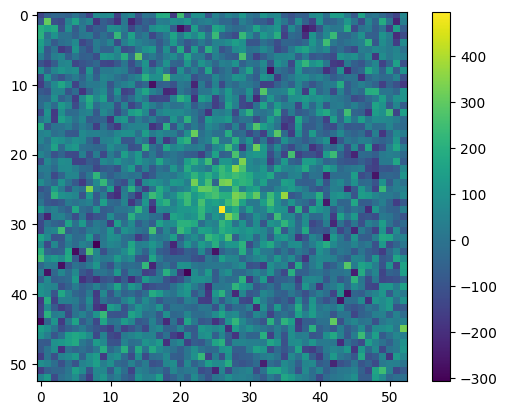

In [52]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [53]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [54]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)
PIXEL_SCALE_GPU = jax.device_put(PIXEL_SCALE, device=GPU)
TEN_GPU = jnp.array(10., device=GPU)
ONE_GPU = jnp.array(1., device=GPU)
PSF_HLR_GPU = jnp.array(PSF_HLR, device=GPU)
SLEN_GPU = jnp.array(SLEN, device=GPU)

def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=TEN_GPU**f, half_light_radius=hlr)
    gal = gal.shift(dx=x*PIXEL_SCALE_GPU, dy=y*PIXEL_SCALE_GPU)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=ONE_GPU, half_light_radius=PSF_HLR_GPU)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN, ## if I change this to SLEN_GPU, get error
                               scale=PIXEL_SCALE_GPU,
                            )
    return image.array

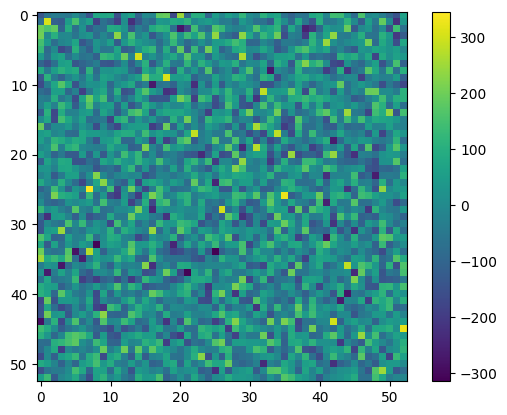

In [55]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

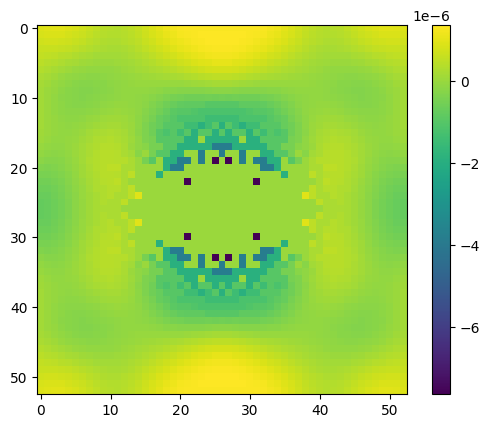

In [56]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [57]:
# timing makes sense
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)

draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU)

%timeit draw_gal_jitted(**TRUE_PARAMS_GPU) # ~ 4x fast
%timeit _draw_gal()

97 μs ± 2.19 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
417 μs ± 17.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [58]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 
          'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': 1,  # sigma (in pixels)
          'y':1 # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [59]:
def _logprob_fn(params, data):    
    #prior
    prior = jnp.array(0., device=GPU) 
    for p in ('f', 'hlr', 'g1', 'g2'): # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)
        
    for p in ('x', 'y'): # normal
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)


# Benchmark 1
Metrics as a function of `n_warmup`, same initial position, same target data, different random seeds. Single warmup for all chains that is shared. We also vary :

- `max_num_doublings` 5 vs 10
- Maximum number of chains we can fit in the gpu, timings for each

Additionally: 

- We make sure timings are on the compiled jitted functions (warmup and inference_loop)

## Setup

In [32]:
SEED = 42

In [33]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)


In [34]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)}


In [35]:
init_positions = {**TRUE_PARAMS_GPU} # all chains start from same position, true position

In [36]:
# what parameter space do we want to explore?
MAX_DOUBLINGS = (5, 10)
N_CHAINS = (1, 5, 10, 25, 50, 100) # probably explodes beyond 1000, starts getting slow ~100
N_WARMUPS = (10, 50, 100, 200, 400, 500, 1000, 2000)

In [37]:
results_dict = {
    'warmup': {
        md:{n_warmups:{} for n_warmups in N_WARMUPS} for md in MAX_DOUBLINGS 
    },
    'inference': {
        md:{n_warmups:{n_chains:{} for n_chains in N_CHAINS} for n_warmups in N_WARMUPS} for md in MAX_DOUBLINGS
    }
}

## Warmup

In [66]:
# warmup function to jit
def call_warmup(rng_key, init_positions, data, n_warmups, max_num_doublings):
    _logdensity = partial(_logprob_fn, data=data)
    warmup = blackjax.window_adaptation(
    blackjax.nuts, _logdensity, progress_bar=False, is_mass_matrix_diagonal=False, 
        max_num_doublings=max_num_doublings, 
        initial_step_size=0.1, 
        target_acceptance_rate=0.90 # sometimes prevents divergences by decrasing final step size, although now priors should be wide enough..
    )
    return warmup.run(rng_key, init_positions, n_warmups) # (init_states, tuned_params), adapt_info

In [67]:
# run a single warmup
print('md, n_warmup')
for md in MAX_DOUBLINGS:
    for n_warmups in N_WARMUPS: # no way to jit over the n_warmup or max_num_doublings
        print(md, n_warmups)
        run_warmup = jjit(partial(call_warmup, n_warmups=n_warmups, max_num_doublings=md))
        
        # compilation time
        t1 = time.time()
        _ = jax.block_until_ready(run_warmup(rng_key, init_positions, data_gpu))
        t2 = time.time()
        results_dict['warmup'][md][n_warmups]['comp_time'] = t2 - t1 
            
            
        # run time
        t1 = time.time()
        (init_states, tuned_params), adapt_info = jax.block_until_ready(run_warmup(rng_key, init_positions, data_gpu))
        t2 = time.time()
        results_dict['warmup'][md][n_warmups]['run_time'] = t2 - t1
        
        # saved parameters to run inference, might also be interesting to track evolution
        results_dict['warmup'][md][n_warmups]['init_states'] = init_states
        results_dict['warmup'][md][n_warmups]['tuned_params'] = tuned_params

print()
print('DONE!')


md, n_warmup
5 10
5 50
5 100
5 200
5 400
5 500
5 1000
5 2000
10 10
10 50
10 100
10 200
10 400
10 500
10 1000
10 2000

DONE!


In [69]:
results_dict['warmup'][5][100]['tuned_params'] # example , includes max_num_doublings

{'inverse_mass_matrix': Array([[ 1.25577273e-03, -1.13884581e-03, -2.63128629e-05,
          1.85616268e-03,  2.92933377e-04, -1.24856660e-03],
        [-1.13884581e-03,  7.81109513e-03, -1.70214832e-03,
         -1.88255003e-03,  3.88071257e-03,  6.38630595e-04],
        [-2.63128629e-05, -1.70214832e-03,  8.97191300e-03,
         -1.79363633e-04, -6.46312275e-03, -1.38636225e-03],
        [ 1.85616268e-03, -1.88255003e-03, -1.79363633e-04,
          7.49203937e-03,  1.40432894e-03, -1.15490537e-03],
        [ 2.92933377e-04,  3.88071257e-03, -6.46312275e-03,
          1.40432894e-03,  1.25862739e-01, -5.54959679e-04],
        [-1.24856660e-03,  6.38630595e-04, -1.38636225e-03,
         -1.15490537e-03, -5.54959679e-04,  6.51052724e-02]],      dtype=float64),
 'max_num_doublings': Array(5, dtype=int64, weak_type=True),
 'step_size': Array(0.40256463, dtype=float64, weak_type=True)}

In [70]:
results_dict['warmup'][5][100]['init_states'].position.keys() # ordering of mass matrix

dict_keys(['f', 'g1', 'g2', 'hlr', 'x', 'y'])

## Inference

Now lets do inference including multilpe chains; we make sure that all chains sample **1000** at least, that way we can compute r-hat, ess for everything.


In [24]:
# vmap only rng_key
def do_inference(rng_key, init_state, data, tuned_params:dict, n_samples:int):
    logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(logdensity, **tuned_params).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=n_samples)
    


In [ ]:
# MAX_DOUBLINGS = 5

N_SAMPLES = 1000
MD = 5

print('md=5, n_warmup, n_chains')
for n_warmups in N_WARMUPS:
    state = results_dict['warmup'][MD][n_warmups]['init_states']
    tuned_params = results_dict['warmup'][MD][n_warmups]['tuned_params']

    for n_chains in N_CHAINS:

        print(n_warmups, n_chains)

        run_inference = jax.vmap(
                        jax.jit(partial(do_inference, tuned_params=tuned_params, n_samples=N_SAMPLES)), 
                        in_axes=(0, None, None)
        )

        keys = random.split(rng_key, n_chains)

        # compilation time
        t1 = time.time()
        _ = jax.block_until_ready(run_inference(keys, state, data_gpu))
        t2 = time.time()
        results_dict['inference'][MD][n_warmups][n_chains]['comp_time'] = t2 - t1 


        # run time
        t1 = time.time()
        states, info = jax.block_until_ready(run_inference(keys, state, data_gpu))
        t2 = time.time()
        results_dict['inference'][MD][n_warmups][n_chains]['run_time'] = t2 - t1

        # save states and info for future reference
        results_dict['inference'][MD][n_warmups][n_chains]['states'] = states
        results_dict['inference'][MD][n_warmups][n_chains]['info'] = info

            
print()
print('DONE!')

In [ ]:

## md = 10 takes too long with low number of warmup steps so we limit to 100+


# MAX_DOUBLINGS = 10

_N_WARMUPS = N_WARMUPS[2:]
N_SAMPLES = 1000
MD = 10
assert jnp.all(_N_WARMUPS > 100)

print('md=10, n_warmup, n_chains')
for n_warmups in _N_WARMUPS:
    state = results_dict['warmup'][MD][n_warmups]['init_states']
    tuned_params = results_dict['warmup'][MD][n_warmups]['tuned_params']

    for n_chains in N_CHAINS:

        print(n_warmups, n_chains)

        run_inference = jax.vmap(
                        jax.jit(partial(do_inference, tuned_params=tuned_params, n_samples=N_SAMPLES)), 
                        in_axes=(0, None, None)
        )

        keys = random.split(rng_key, n_chains)

        # compilation time
        t1 = time.time()
        _ = jax.block_until_ready(run_inference(keys, state, data_gpu))
        t2 = time.time()
        results_dict['inference'][MD][n_warmups][n_chains]['comp_time'] = t2 - t1 


        # run time
        t1 = time.time()
        states, info = jax.block_until_ready(run_inference(keys, state, data_gpu))
        t2 = time.time()
        results_dict['inference'][MD][n_warmups][n_chains]['run_time'] = t2 - t1

        # save states and info for future reference
        results_dict['inference'][MD][n_warmups][n_chains]['states'] = states
        results_dict['inference'][MD][n_warmups][n_chains]['info'] = info

            
print()
print('DONE!')


## save results

In [ ]:
# jnp.save('results_benchmark-v1.npy', results_dict)

## Consolidate results

In [60]:
d = jnp.load('results_benchmark-v1.npy', allow_pickle=True)[()]

In [61]:
d.keys()

dict_keys(['warmup', 'inference'])

In [62]:
d['inference'][5][10][10]['states'].position['f'].shape

(10, 1000)

In [63]:
N_WARMUPS

(10, 50, 100, 200, 400, 500, 1000, 2000)

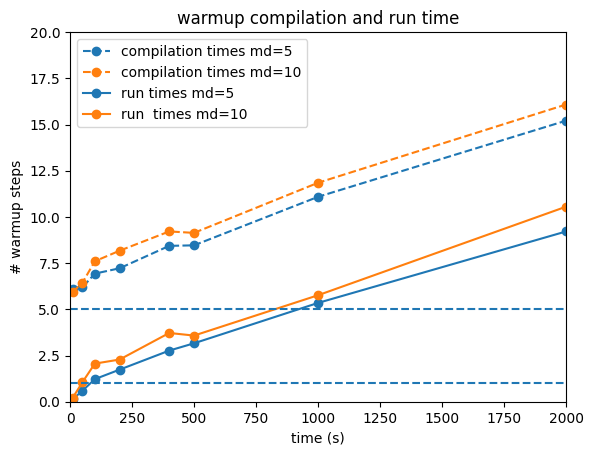

In [64]:
plt.title("warmup compilation and run time")

comp_times1 = [d['warmup'][5][n]['comp_time'] for n in N_WARMUPS]
comp_times2 = [d['warmup'][10][n]['comp_time'] for n in N_WARMUPS]

run_times1 = [d['warmup'][5][n]['run_time'] for n in N_WARMUPS]
run_times2 = [d['warmup'][10][n]['run_time'] for n in N_WARMUPS]


plt.plot(N_WARMUPS, comp_times1, '--o', label='compilation times md=5', color='C0')
plt.plot(N_WARMUPS, comp_times2, '--o', label='compilation times md=10', color='C1')

plt.plot(N_WARMUPS, run_times1, '-o', label='run times md=5', color='C0')
plt.plot(N_WARMUPS, run_times2, '-o', label='run  times md=10', color='C1')

plt.xlabel("time (s)")
plt.ylabel("# warmup steps")

plt.xlim(0, 2000)
plt.ylim(0, 20)
plt.legend()

plt.axhline(1.0, linestyle='--')
plt.axhline(5.0, linestyle='--')

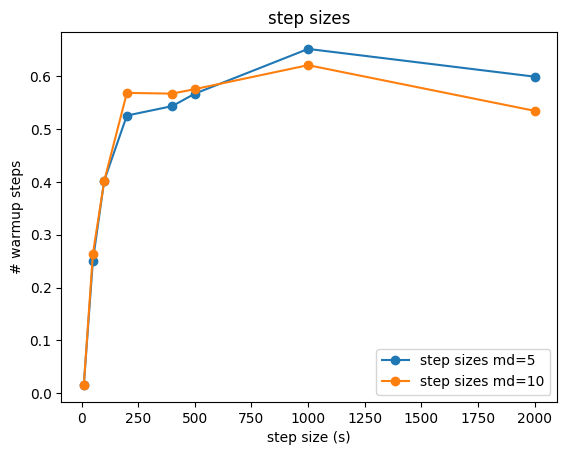

In [65]:
plt.title("step sizes")

step_sizes1 = [d['warmup'][5][n]['tuned_params']['step_size'] for n in N_WARMUPS]
step_sizes2 = [d['warmup'][10][n]['tuned_params']['step_size'] for n in N_WARMUPS]


plt.plot(N_WARMUPS, step_sizes1, '-o', label='step sizes md=5', color='C0')
plt.plot(N_WARMUPS, step_sizes2, '-o', label='step sizes md=10', color='C1')

plt.xlabel("step size (s)")
plt.ylabel("# warmup steps")

plt.legend()



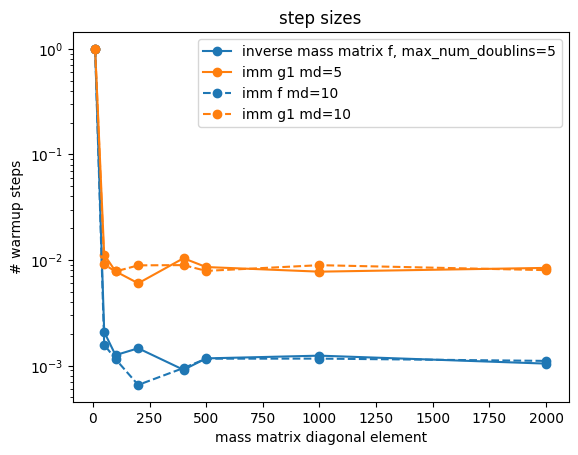

In [66]:
plt.title("step sizes")

mm11 = [d['warmup'][5][n]['tuned_params']['inverse_mass_matrix'][0,0] for n in N_WARMUPS]# f
mm12 = [d['warmup'][5][n]['tuned_params']['inverse_mass_matrix'][1, 1] for n in N_WARMUPS] # g1

mm21 = [d['warmup'][10][n]['tuned_params']['inverse_mass_matrix'][0,0] for n in N_WARMUPS]# f
mm22 = [d['warmup'][10][n]['tuned_params']['inverse_mass_matrix'][1, 1] for n in N_WARMUPS] # g1


plt.plot(N_WARMUPS, mm11, '-o', label='inverse mass matrix f, max_num_doublins=5', color='C0')
plt.plot(N_WARMUPS, mm12, '-o', label='imm g1 md=5', color='C1')

plt.plot(N_WARMUPS, mm21, '--o', label='imm f md=10', color='C0')
plt.plot(N_WARMUPS, mm22, '--o', label='imm g1 md=10', color='C1')


plt.xlabel("mass matrix diagonal element")
plt.ylabel("# warmup steps")

plt.legend()

plt.yscale('log')



In [71]:
N_WARMUPS

(10, 50, 100, 200, 400, 500, 1000, 2000)

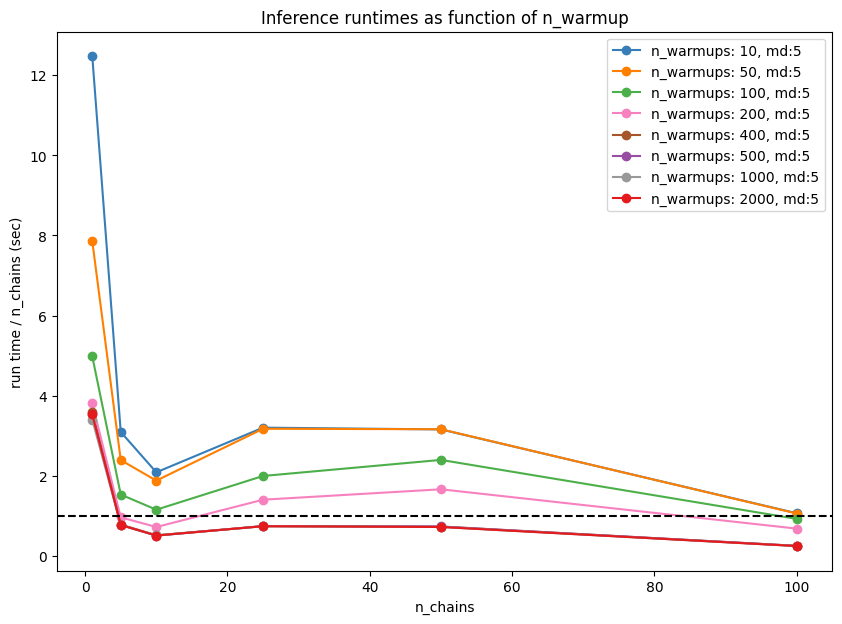

In [80]:
# run_time / compilation time as of n_chains, md (keep in mind 1000 samples for every chain)
# divide run_time by n_chains to account for more samples for higher n_chains

plt.figure(figsize=(10,7))
plt.title("Inference runtimes as function of n_warmup and n_chains")

for ii, n_warmups in enumerate(N_WARMUPS):

    rt1 = [d['inference'][5][n_warmups][n_chains]['run_time'] / n_chains for n_chains in N_CHAINS]
    # run_times2 = [results_dict['inference'][10][n_warmups][n_chains]['run_time'] for n_chains in N_CHAINS]
    
    plt.plot(N_CHAINS, rt1, '-o', label=f'n_warmups: {n_warmups}, md:5', color=CB_color_cycle[ii])
    # plt.plot(N_CHAINS, run_times2, '--o', label=f'n_warmups: {n_warmups}, md:10', color=colors[ii])

plt.axhline(1.0, color='k', linestyle='--')
plt.xlabel("n_chains")
plt.ylabel("run time / n_chains (sec)")
plt.legend()

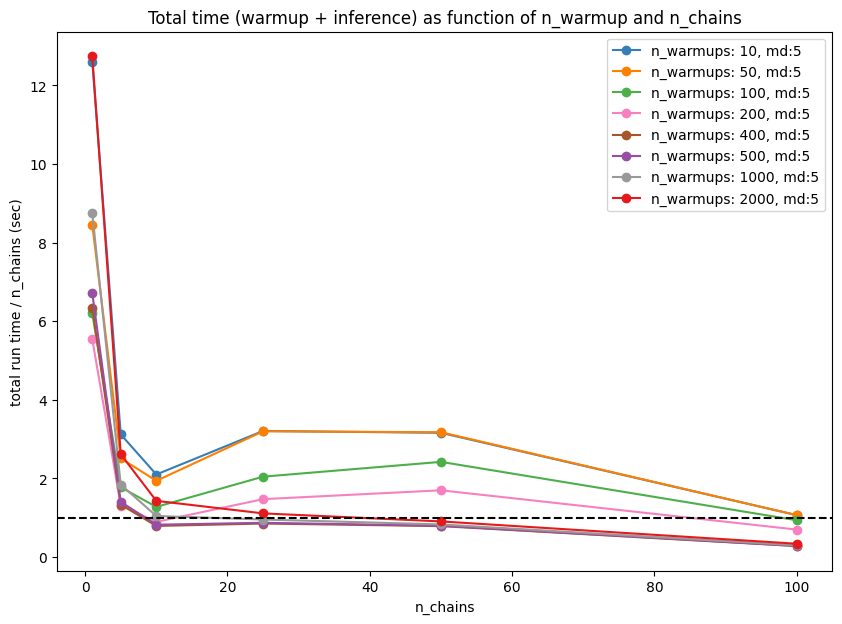

In [83]:
# run_time / compilation time as of n_chains, md (keep in mind 1000 samples for every chain)
# divide run_time by n_chains to account for more samples for higher n_chains

plt.figure(figsize=(10,7))
plt.title("Total time (warmup + inference) as function of n_warmup and n_chains")

for ii, n_warmups in enumerate(N_WARMUPS):

    rt1 = [d['inference'][5][n_warmups][n_chains]['run_time'] for n_chains in N_CHAINS]
    wt1 = [d['warmup'][5][n_warmups]['run_time'] for n_chains in N_CHAINS]
    tt1 = [(r + w) / n_chains for (r, w, n_chains) in zip(rt1, wt1, N_CHAINS)]
    
    plt.plot(N_CHAINS, tt1, '-o', label=f'n_warmups: {n_warmups}, md:5', color=CB_color_cycle[ii])

plt.axhline(1.0, color='k', linestyle='--')
plt.xlabel("n_chains")
plt.ylabel("total run time / n_chains (sec)")
plt.legend()

In [122]:
d['inference'][5][1000][100]['run_time'], d['warmup'][5][1000]['run_time']

(24.367305994033813, 5.346411466598511)

In [89]:
d['inference'][5][10][5]['states'].position['f'].shape # (chains, samples)

(5, 1000)

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


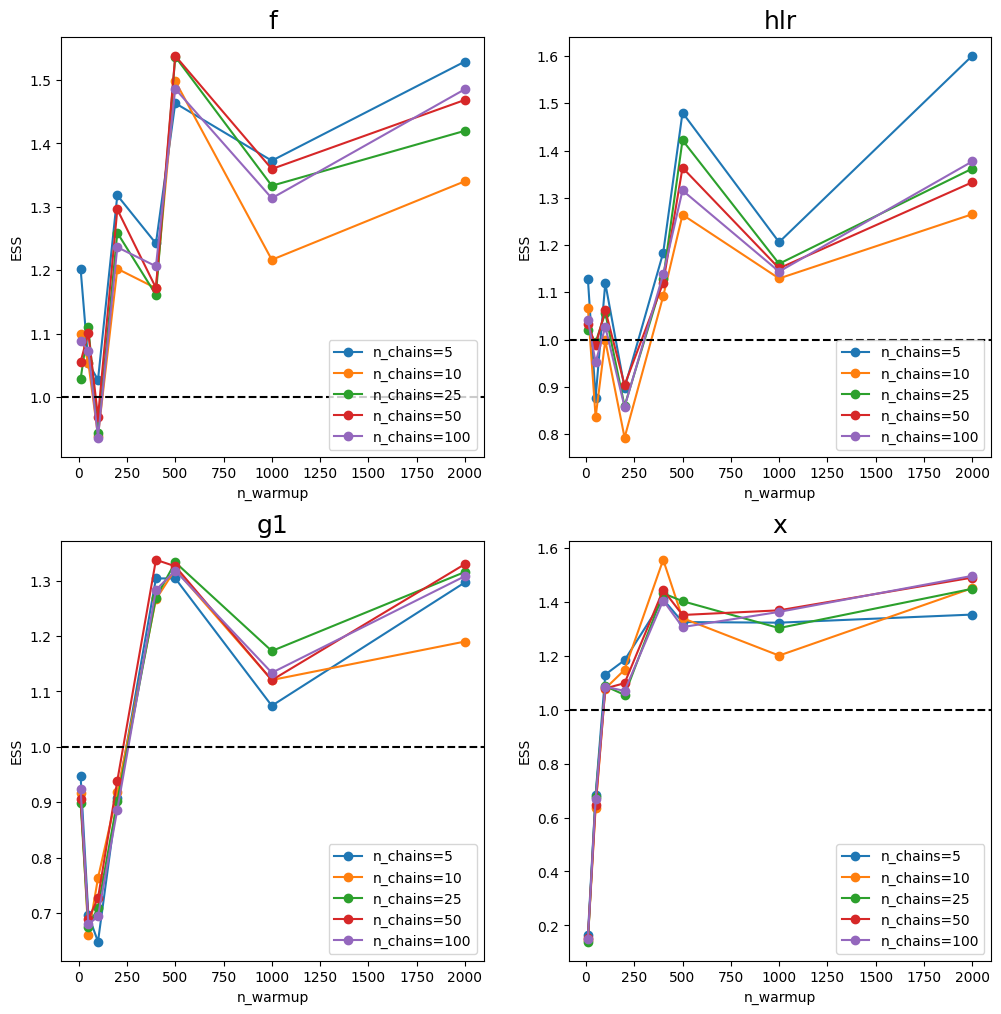

In [101]:
# ESS as a function of n_warmups, md for # chains > 1
# for f, hlr, g1, x in 4 separate panels

fig, axes = plt.subplots(2, 2,figsize=(12, 12)) 
axis = axes.ravel()

_N_CHAINS = N_CHAINS[1:] # avoid 1 as can't calcualte r-hat


ps = ('f', 'hlr', 'g1', 'x')
ess = {p:{n:{} for n in _N_CHAINS} for p in ps}
for ii, ax in enumerate(axis):
    p = ps[ii]
    for n_chains in tqdm(_N_CHAINS):
        assert n_chains > 1
        ess[p][n_chains] = [effective_sample_size(d['inference'][5][n_warmups][n_chains]['states'].position[p], chain_axis=0, sample_axis=1)/ (1000*n_chains) # total samples 
                            for n_warmups in N_WARMUPS
                           ]
        
    for n_chains in _N_CHAINS:
        ax.plot(N_WARMUPS, ess[p][n_chains], '-o', label=f'n_chains={n_chains}')
    ax.legend()
    ax.axhline(1.0, color='k', linestyle='--')
    ax.set_title(p, fontsize=18)
    ax.set_ylabel("ESS")
    ax.set_xlabel("n_warmup")


100%|██████████| 5/5 [00:00<00:00, 179.69it/s]


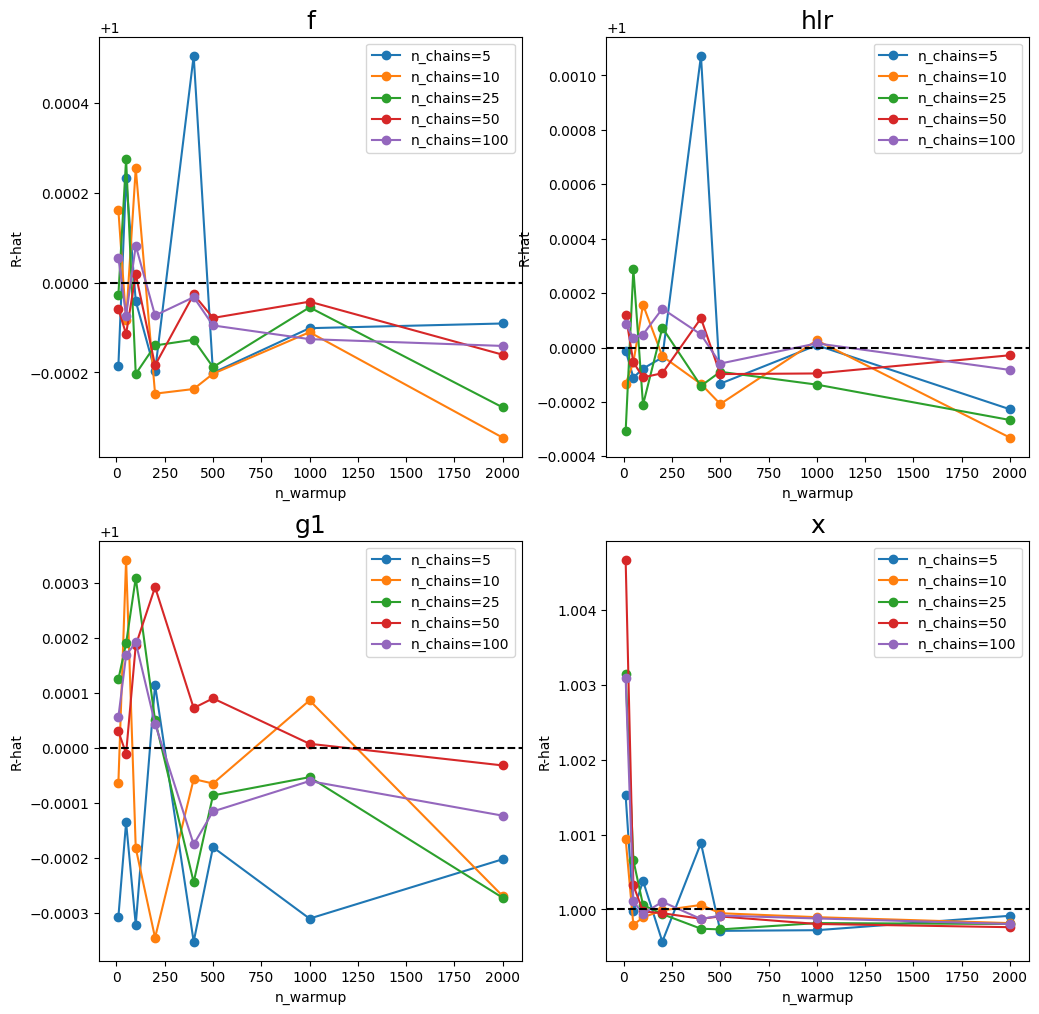

In [103]:
# Rhat as a function of n_warmup for # chains > 1
# for f, hlr, g1, x in 4 separate panels

fig, axes = plt.subplots(2, 2,figsize=(12, 12)) 
axis = axes.ravel()

_N_CHAINS = N_CHAINS[1:] # avoid 1 as can't calcualte r-hat


ps = ('f', 'hlr', 'g1', 'x')
rhat = {p:{n:{} for n in _N_CHAINS} for p in ps}
for ii, ax in enumerate(axis):
    p = ps[ii]
    for n_chains in tqdm(_N_CHAINS):
        assert n_chains > 1
        rhat[p][n_chains] = [potential_scale_reduction(d['inference'][5][n_warmups][n_chains]['states'].position[p], chain_axis=0, sample_axis=1) # total samples 
                            for n_warmups in N_WARMUPS
                           ]
        
    for n_chains in _N_CHAINS:
        ax.plot(N_WARMUPS, rhat[p][n_chains], '-o', label=f'n_chains={n_chains}')
    ax.legend()
    ax.axhline(1.0, color='k', linestyle='--')
    ax.set_title(p, fontsize=18)
    ax.set_ylabel("R-hat")
    ax.set_xlabel("n_warmup")


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


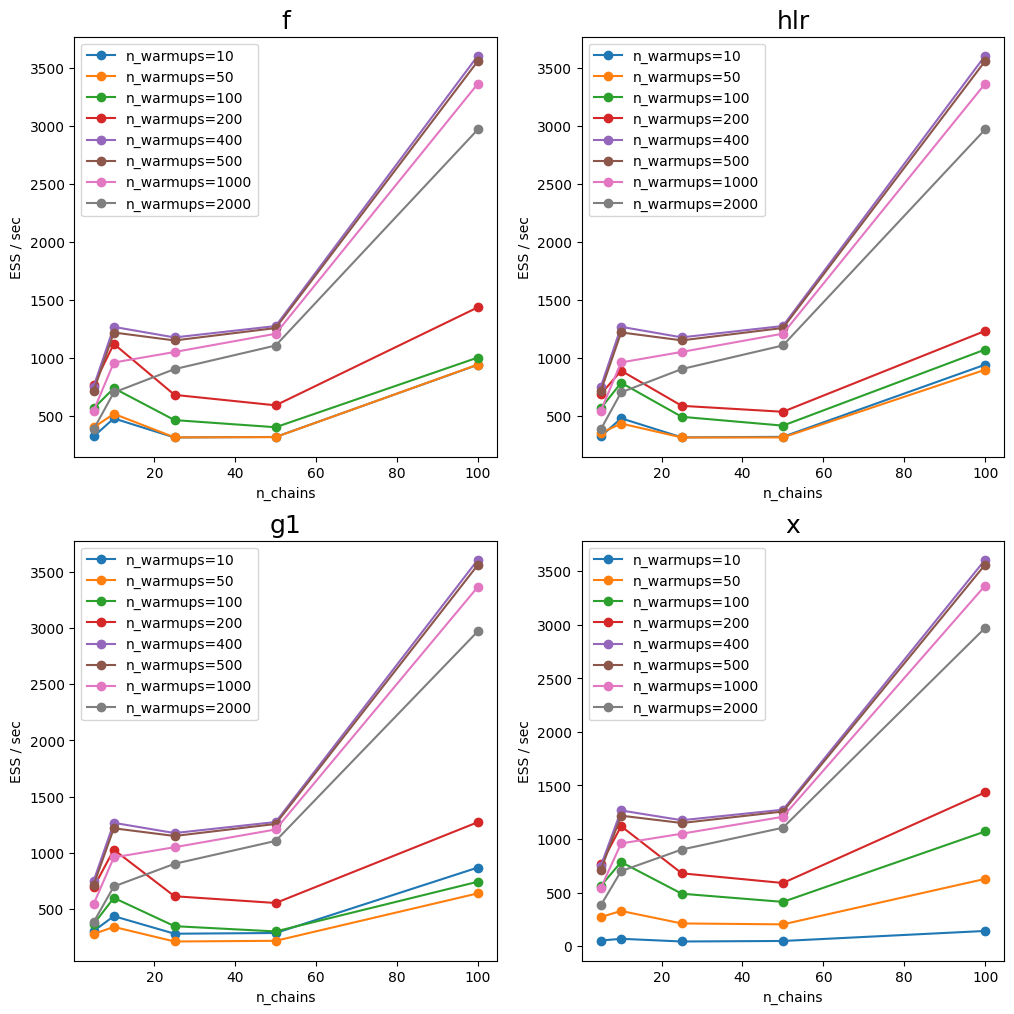

In [109]:
# ess / sec as a function of n_chains
# relative ess will be clipped to 1.0
# for f, hlr, g1, x in 4 separate panels

fig, axes = plt.subplots(2, 2,figsize=(12, 12)) 
axis = axes.ravel()

_N_CHAINS = N_CHAINS[1:] # avoid 1 as can't calcualte r-hat


ps = ('f', 'hlr', 'g1', 'x')
ess = {p:{n:{} for n in N_WARMUPS} for p in ps}
for ii, ax in enumerate(axis):
    p = ps[ii]
    for n_warmups in tqdm(N_WARMUPS):
        res = []
        for n_chains in _N_CHAINS:
            assert n_chains > 1
            _ess = effective_sample_size(d['inference'][5][n_warmups][n_chains]['states'].position[p], chain_axis=0, sample_axis=1)
            rt = d['inference'][5][n_warmups][n_chains]['run_time']
            wt = d['warmup'][5][n_warmups]['run_time']
            res.append(jnp.clip(_ess, max=1000 * n_chains) / (wt + rt))
        ess[p][n_warmups] = res
        
    for n_warmups in N_WARMUPS:
        ax.plot(_N_CHAINS, ess[p][n_warmups], '-o', label=f'n_warmups={n_warmups}')
    ax.legend()
    # ax.axhline(1.0, color='k', linestyle='--')
    ax.set_title(p, fontsize=18)
    ax.set_ylabel("ESS / sec")
    ax.set_xlabel("n_chains")


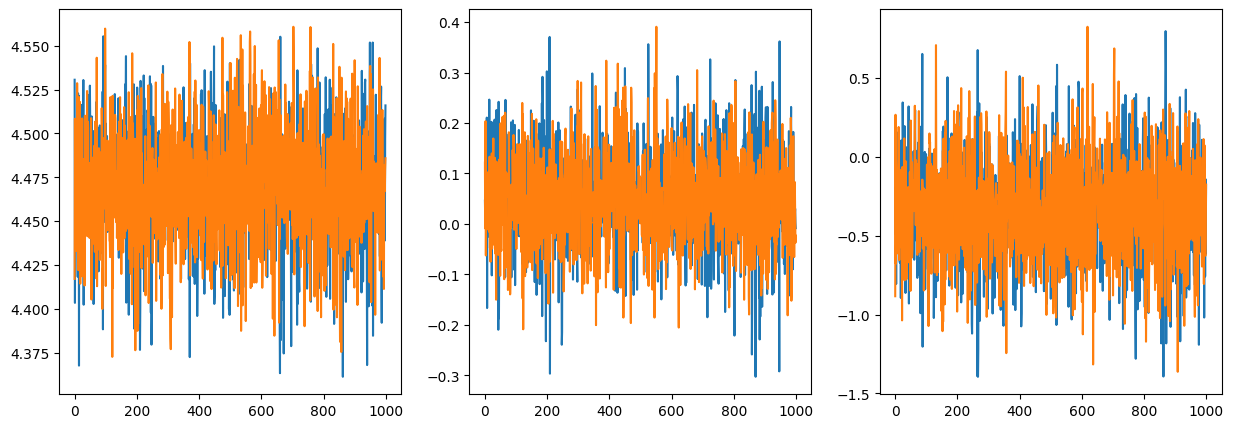

In [107]:
# some example chains f, g1, x
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

samples1 = d['inference'][5][500][10]['states'].position
ax1.plot(samples1['f'][0, :])
ax1.plot(samples1['f'][1, :])
ax2.plot(samples1['g1'][0, :])
ax2.plot(samples1['g1'][1, :])
ax3.plot(samples1['x'][0, :])
ax3.plot(samples1['x'][1, :])

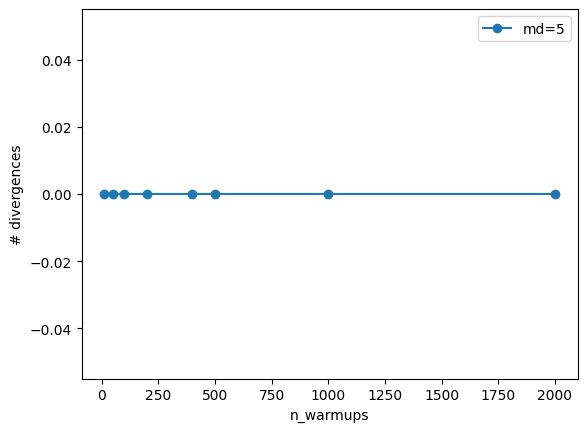

In [108]:
# divergences as function of n_warmups
# NO DIVERGENCES!

colors = ['C0', 'C1', 'C2', 'C3']

divs = [d['inference'][5][n_warmups][5]['info'].is_divergent.sum() for n_warmups in N_WARMUPS]

plt.plot(N_WARMUPS, divs, '-o', label='md=5')

plt.xlabel("n_warmups")
plt.ylabel("# divergences")
plt.legend()